In [ ]:
# smemp_apf_test.ipynb
# Version of smemp_multifile.ipynb for running a single APF star. Used for testing new code before adding to
# smemp_multife.ipynb. 
# Last modified 8/13/20 by Anna Zuckerman 


In [ ]:
# ADZ ADD: to allow importing .ipynb scripts 
!pip install import-ipynb

In [ ]:
# BELOW IS FROM Cameron Nunez's smemp.py (except where labelled) 
"""
@filename smemp_apf_test.py

Derive properties of target stars using the Empirical SpecMatch algorithm and
write them to a csv file.
Display plots and figures of the process (optional).
"""
import import_ipynb #ADZ ADD 6/23/20
import sys, os
from os import listdir
from os.path import isfile, join
import csv
from pylab import *
import pylab
import astropy.io.fits as pf
sys.path.append('specmatch-emp')
import specmatchemp.library
import specmatchemp.plots as smplot
from specmatchemp.spectrum import Spectrum
from specmatchemp.specmatch import SpecMatch
#from deblaze import afs_deblaze
from rescale import get_rescaled_wave_soln
from rescale import resample
from optparse import OptionParser
#from deblaze_func import normalized_registered_and_deblazed_array #ADZ ADD 6/23/20 (this is Jackie Telson's function)
from bstar_deblaze import bstar_deblazed2

In [2]:
def write_results(fd, my_spectrum, sm, write_new = False):
    """
    Write to a csv the derived properties of a target following
    the SpecMatch process
    Args:
        fd (File): object for the csv file to write to
        my_spectrum (spectrum.Spectrum): Target spectrum
        sm (specmatch.SpecMatch): Contains results of the algorithm
        write_new (Boolean): Whether to write to a new csv file
    """

    fieldnames = ['apf_name', 'Teff', 'u_Teff','radius','u_radius',
                  'logg','u_logg', 'feh','u_feh','mass','u_mass','age',
                  'u_age', 'best_mean_chi_squared']

    thewriter = csv.DictWriter(fd, fieldnames=fieldnames)

    if (write_new): thewriter.writeheader()

    thewriter.writerow({'apf_name' : my_spectrum.name,
                        'Teff' : '{0:.3f}'.format(sm.results['Teff']),
                        'u_Teff' : '{0:.3f}'.format(sm.results['u_Teff']),
                        'radius' : '{0:.3f}'.format(sm.results['radius']),
                        'u_radius' : '{0:.3f}'.format(sm.results['u_radius']),
                        'logg' : '{0:.3f}'.format(sm.results['logg']),
                        'u_logg' : '{0:.3f}'.format(sm.results['u_logg']),
                        'feh' : '{0:.3f}'.format(sm.results['feh']),
                        'u_feh' : '{0:.2f}'.format(sm.results['u_feh']),
                        'mass' : '{0:.3f}'.format(sm.results['mass']),
                        'u_mass' : '{0:.3f}'.format(sm.results['u_mass']),
                        'age' : '{0:.2f}'.format(sm.results['age']),
                        'u_age' : '{0:.2f}'.format(sm.results['u_age']),
                        'best_mean_chi_squared' :
                        '{0:.2f}'.format(best_mean_chi_squared)})

parser = OptionParser()
parser.add_option("-f", "--file", action='store', type='string',
                  dest="pathname",
                  help="pass the path of the FITS file(s) as an argument")
parser.add_option("-o", action='store', type='string',
                  dest="outputpath",
                  help="pass the path to a csv file to write to "
                       "as an argument")
parser.add_option("-p", action="store_true", dest="plot",
                  help='plot')
parser.add_option("--all", action="store_true", dest="all",
                  help='plots all wavelength regions')
parser.add_option("--best", action="store_true", dest="best",
                  help='plots the reference, modified reference and residuals '
                       'for each of the best matches.')
parser.add_option("--chi", action="store_true", dest="chi",
                  help='plot the chi-squared surface from the pairwise \
                  matching procedure')
parser.add_option("--ref", action="store_true", dest="ref",
                  help='plot the locations of the best references used in the \
                  linear combination step')
parser.add_option("--sr", action="store_true", dest="ref",
                  help='save the residuals ')

(options, sys.argv) = parser.parse_args(sys.argv)

print('EMPIRICAL SPECMATCH'), print()

# if no path given in command, prompt user for a path to a file or a directory
# from which to acquire fits files
# NOTE: program currently only known to work if all the files in the directory
# are fits files and are intended targets

#del pathname #ADZ REMOVE IF AND ELSE othewise, on the first run after restarting kernel it thinks 
# options.pathname is not None and so never asks for file
#if (options.pathname == None):
path_name = input('Enter the path to a single, or direcotry of, APF fits file(s): ') # ADZ change 7/22/20
print()
#else:
#    path_name = options.pathname
    
try:
    filenames = [f for f in listdir(path_name) if isfile(join(path_name, f))]
except NotADirectoryError: # path to one file
    path_split = path_name.split('/')
    path_split[:-1] = ['/'.join(path_split[:-1])]
    filenames = []
    filename = path_split[-1]
    filenames.append(filename)
    path_name = path_split[0]

# check to see if files are for the same star
# NOTE: program currently does not work if the input directory contains fits
# files for multiple stars
names = set()

#ADZ ADD FOR DEBUGGING 6/23/20
#try:
#    print(pathname)
#except NameError:
#    print('nope, no pathname yet')
#for filename in filenames:
#    print('I think the filename is: ' + filename)

for filename in filenames:
    #print(filename) #ADZ ADD FOR DEBUGGING
    file = pf.open(path_name + '/' + filename,ignore_missing_end=True) #ADZ ADD ignore_missing_end=True
    header = file[0].header
    name = header['TOBJECT']
    names.add(name)
    if (len(names) > 1):
        print('Spectra Addition Error: ')
        print('This program sums the spectra for a star.')
        print('Please only provide the path to FITS files for the same star' +
              ' for a run of this program.')
        sys.exit()

display_plots = False #ADZ CHANGE from False
if (options.plot or options.chi or options.best or options.ref):
    display_plots = True # bool var for whether or not to display plots

# Prompt for regions to plot
if ((display_plots) and (options.all == None)):
    print("0 : 5000 to 5100 Å")
    print("1 : 5100 to 5200 Å")
    print("2 : 5200 to 5300 Å")
    print("3 : 5300 to 5400 Å")
    print("4 : 5400 to 5500 Å")
    print("5 : 5500 to 5600 Å")
    print("6 : 5600 to 5700 Å")
    print("7 : 5700 to 5800 Å")
    print("8 : 5800 to 5900 Å")
    print("Please enter the corresponding numbers for " +
          "the wavelength regions to be plotted.")
    print("Separate the numbers with spaces.")
    print("Default option is only region 1. Simply press enter for " +
          "default option.")
    print("Enter \'all\' to plot all the regions.")

    while(True):
        inp = input('→ ')
        try:
            if (inp == ''): # Default - plot region 1
                regions = [1]
            elif (inp == 'all'):
                regions = (list(range(9)))
            else:
                regions = [int(region) for region in sort(inp.split(" "))]
                if (False in [(0 <= region <= 8) for region in regions]):
                    continue
        except ValueError: continue
        break

else: # plot all
    regions = (list(range(9)))

# Read in data from wavelength solution
wave_soln = (pf.open('apf_wav.fits'))[0].data

# Sum all of the data files for a star
data = np.zeros((79, 4608))

ve = False
counter  = 0
for filename in filenames:
    file = pf.open(path_name + '/' + filename)
    data_part = file[0].data
    if counter == 0: # get the header from the first file for this star, to use for the residual fits file #ADZ ADD 7/26
        use_header = file[0].header
    counter += 1
    if (str(np.shape(data_part)) != '(79, 4608)'):
        print(str(np.shape(data_part)) + ' is an incompatible data shape.')
        print('Cannot perform shift-and-match process.')
        sys.exit()
    try:
        data += data_part
    except ValueError:
        ve = True

if (ve):
    print("Value Error occurred during spectra summation.")

header = file[0].header
name = header['TOBJECT']
print('Running SpecMatch-Emp on ' + name + ':')
for filename in filenames:
    print(filename)

ve = False
#Deblaze the orders: 31 to 52 (range of focus in the SME library)
for order_inc in range(22):
    try: #ADZ CHANGE THIS TRY STATEMENT 6/23/20 to use JT's deblaze function #ADZ CHANGE 7/17/20 to use B-star deblaze 
       # data[30 + order_inc, :4607] = afs_deblaze(data[30 + order_inc],
       #                                           30 + order_inc)[0]
        data[30 + order_inc, :4600] = bstar_deblazed2(data,30 + order_inc)
    except ValueError: ve = True

if (ve): print("Value Error occurred during blaze correction.")
    
    
#ADZ add -- remove cosmic rays from normalized, deblazed spectrum
remove_cosmic_rays = True
def remove_cosmic_rays(spect): # must input a normalized, deblazed spectrum
    new_spect = spect 
    for i in range(len(spect)):
        old_value = spect[i]
        if old_value > 1.4:
            new_value = np.median(spect[i-3:i+3])
            new_spect[i] = new_value # Other way would be to make this spect[i] not new_spect[i], then return spect
            print('replaced value ' + str(old_value) + ' with '+ str(new_value) +' at ' + str(i))
    return new_spect
if remove_cosmic_rays == True:
    data = remove_cosmic_rays(data)
    
    
# Get a wavelength solution rescaled onto the scale of the library
wave_soln_ref = get_rescaled_wave_soln()

# Resample the spectrum onto the new wavelength scale
data_new = resample(wave_soln_ref, wave_soln, data)

# Create spectrum object
my_spectrum = Spectrum(np.asarray(wave_soln_ref), np.asarray(data_new))
my_spectrum.name = name

lib = specmatchemp.library.read_hdf()

sm = SpecMatch(my_spectrum, lib)

# Perform shift
sm.shift()

# Perform match
sm.match()

# Perform lincomb
sm.lincomb()

# Chi squared values of the best match
chi_squares = []

chi_squares.append(sm.match_results.iloc[0]['chi_squared_5000'])
chi_squares.append(sm.match_results.iloc[0]['chi_squared_5100'])
chi_squares.append(sm.match_results.iloc[0]['chi_squared_5200'])
chi_squares.append(sm.match_results.iloc[0]['chi_squared_5300'])
chi_squares.append(sm.match_results.iloc[0]['chi_squared_5400'])
chi_squares.append(sm.match_results.iloc[0]['chi_squared_5500'])
chi_squares.append(sm.match_results.iloc[0]['chi_squared_5600'])
chi_squares.append(sm.match_results.iloc[0]['chi_squared_5700'])
chi_squares.append(sm.match_results.iloc[0]['chi_squared_5800'])

best_mean_chi_squared = np.mean(np.asarray(chi_squares))

# Record results to csv file
# if not provided a output file name, temp.csv is written to
# (and created if not already)
if (options.outputpath != None):
    if (not options.outputpath.endswith('.csv')):
        if (not options.outputpath.endswith('/')):
            options.outputpath += '/'
        options.outputpath += 'temp.csv'
    if isfile(options.outputpath):
        with open(options.outputpath,'a') as fd:
            write_results(fd, my_spectrum, sm)
    else:
        with open(options.outputpath, 'w', newline='') as fd:
            write_results(fd, my_spectrum, sm, write_new = True)
else:
    if isfile('temp.csv'):
        with open('temp.csv','a') as fd: write_results(fd, my_spectrum, sm)
    else:
        with open('temp.csv', 'w', newline='') as fd:
            write_results(fd, my_spectrum, sm, write_new = True)

if (display_plots):

    # Plot figures
    fignum = 0
    for r in regions:

        if (options.chi):
            fignum += 1
            plt.figure(fignum)
            fig3 = pylab.gcf()
            fig3.canvas.set_window_title('Chi-Squared Surface: Region ' + str(r))
            sm.plot_chi_squared_surface(region=r, num_best=None)

        if (options.best):
            fignum += 1
            plt.figure(fignum)
            fig1 = pylab.gcf()
            fig1.canvas.set_window_title('Best Match Spectra: Region ' + str(r))
            sm.plot_best_match_spectra(region=r, wavlim='all', num_best=None)

        if (options.ref):
            fignum += 1
            plt.figure(fignum)
            fig2 = pylab.gcf()
            fig2.canvas.set_window_title('References: Region ' + str(r))
            sm.plot_references(region=r, num_best=None, verbose=True)

        fignum += 1
        plt.figure(fignum)
        fig = pylab.gcf()
        fig.canvas.set_window_title('Linear Combination: Region ' + str(r))
        sm.plot_lincomb(region=r, wavlim='all')

        plt.show()

    # Plot shift  # ADZ COMMENT OUT THIS CHUNK 7/6
    #fignum += 1
    #plt.figure(fignum, figsize=(10,5))
    #fig4 = pylab.gcf()
    #fig4.canvas.set_window_title('Shift')
    #sm.target_unshifted.plot(normalize=True, plt_kw={'color':'forestgreen'},
    #                         text='Target (unshifted)')
    #sm.target.plot(offset=0.5, plt_kw={'color':'royalblue'},
    #               text='Target: ' + name + ' (shifted)')
    #sm.shift_ref.plot(offset=1, plt_kw={'color':'firebrick'},
    #                  text='Reference: ' +sm.shift_ref.name)
    #plt.xlim(5160,5190)
    #plt.ylim(0,2.2)

    #plt.show()
    
# ADZ ADD 7/9/20
def get_residual(): # returns residual between target scpectrum and lin. comb. of best match spectra
    mt_lincomb = sm.lincomb_matches[0:9]
    wl_regions = [[5000,5100],[5101,5200],[5201,5300],[5301,5400],[5401,5500],[5501,5600],[5601,5700],[5701,5800],[5801,5900]]
    wl_all_regions = np.zeros([0,0])
    residual_all_regions = np.zeros([0,0])
    for n in range(9): 
        residual = mt_lincomb[n].modified.s - mt_lincomb[n].target.s
        wl = np.linspace(wl_regions[n][0], wl_regions[n][1], len(residual))
        residual_all_regions = np.append(residual_all_regions, residual)
        wl_all_regions = np.append(wl_all_regions, wl) 
    resid_results = np.vstack([residual_all_regions, wl_all_regions])
    return (resid_results)

# get number of pixels spectrum was shifted during sm.shift() 
pixel_shift = np.median(sm.shift_data['lag'])

# save the Specmatch object
sm_save_path = './SM_Objects'
sm.to_hdf(sm_save_path)

#residuals = get_residual()

print('COMPLETE')

# Example spectrum at -> ./APF_spectra/apf_spectra_highest_SNR/HIP101345_spectra

EMPIRICAL SPECMATCH



Enter the path to a single, or direcotry of, APF fits file(s):  ./APF_spectra/apf_spectra_highest_SNR/HIP101345_spectra



Running SpecMatch-Emp on 195564:
ragx.186.fits
ragx.187.fits
ragx.188.fits
ragx.189.fits
ragx.190.fits
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished deblaze
Finished rescale
Finished resample
Reading library from /home/azuckerman/.specmatchemp/library.h5
Shifting spectrum
Shifting spectrum 195564
Attempting shift to spectrum NSO, median cross-correlation peak = 1.78
Attempting shift to spectrum 123239, median cross-correlation peak = 1.84
Attempting shift to spectrum 222368, median cross-correlation peak = 1.01
Attempting shift to spectrum 216899, median cross-correlation peak = 0.95
Best reference for shifting: 123239
Shifting entire spectrum
Matching spectrum
Matching 

In [211]:
# --------------------------------------------   TESTING BELOW HERE ---------------------------------------------

#check lenghts of matching regions
mt_lincomb = sm.lincomb_matches[0:9]
lens3 = [len(mt_lincomb[0].modified.s),len(mt_lincomb[1].modified.s),len(mt_lincomb[2].modified.s),len(mt_lincomb[3].modified.s),len(mt_lincomb[4].modified.s),len(mt_lincomb[5].modified.s),len(mt_lincomb[6].modified.s),len(mt_lincomb[7].modified.s),len(mt_lincomb[8].modified.s)] 
print(lens1)
print(lens2)
print(lens3)

[5835, 5722, 5612, 5508, 5406, 5309, 5216, 5124, 5037]
[5835, 5722, 5612, 5508, 5406, 5309, 5216, 5124, 5037]
[5835, 5722, 5612, 5508, 5406, 5309, 5216, 5124, 5037]


In [19]:
# check initial method of returning residuals
def get_residual(): # returns residual between target scpectrum and lin. comb. of best match spectra
    mt_lincomb = sm.lincomb_matches[0:9]
    wl_regions = [[5000,5100],[5101,5200],[5201,5300],[5301,5400],[5401,5500],[5501,5600],[5601,5700],[5701,5800],[5801,5900]]
    wl_all_regions = np.zeros([0,0])
    residual_all_regions = np.zeros([0,0])
    for n in range(9): 
        residual = mt_lincomb[n].modified.s - mt_lincomb[n].target.s
        wl = np.linspace(wl_regions[n][0], wl_regions[n][1], len(residual))
        residual_all_regions = np.append(residual_all_regions, residual)
        wl_all_regions = np.append(wl_all_regions, wl) 
    #resid_results = np.vstack([residual_all_regions, wl_all_regions])
    return (residual_all_regions, wl_all_regions)

import pandas as pd
test_results1 = get_residual
results = pd.DataFrame(get_residual(), index = ['Residual','Wavelength [A]'])
test_results1.to_csv('test_resid.csv')

In [194]:
# check one way of storing the residuals
# Do run for one star first
from csv import writer  
with open('test.csv', 'a+', newline='') as write_obj:
    csv_writer = writer(write_obj)
    csv_writer.writerow(['starname', 'NOTE: laste row is wavelenghts']) 
    
from csv import writer  
with open('test.csv', 'a+', newline='') as write_obj:
    csv_writer = writer(write_obj)
    csv_writer.writerow(['starname here'] + get_residual().tolist())   
    
wl_regions = [[5000,5100],[5101,5200],[5201,5300],[5301,5400],[5401,5500],[5501,5600],[5601,5700],[5701,5800],[5801,5900]]
wl_all_regions = np.zeros([0,0])
for n in range(9): 
    wl = np.linspace(wl_regions[n][0], wl_regions[n][1], len(residual))
    wl_all_regions = np.append(wl_all_regions, wl) 

from csv import writer  
with open('test.csv', 'a+', newline='') as write_obj:
    csv_writer = writer(write_obj)
    csv_writer.writerow(['wavlengths',wl_all_regions])   

In [17]:
import astropy.io.fits as pf
from astropy.io import fits

In [20]:
# check one method of saving residuals
residuals, wl = get_residual()
use_header.set('RESID', 'YES','Residual output of Specmatch-emp')
use_header.set('SPECT', str(filenames).replace(']','').replace('[','').replace('\'','') ,'Spectra files used for target spectrum')
data_hdu = fits.PrimaryHDU(residuals, use_header)
wl_hdu = fits.ImageHDU(wl)
hdu = fits.HDUList([data_hdu, wl_hdu])
hdu.writeto('APF_spectra/Residuals/' + 'test_spect')

Text(0, 0.5, 'Difference between scales [A]')

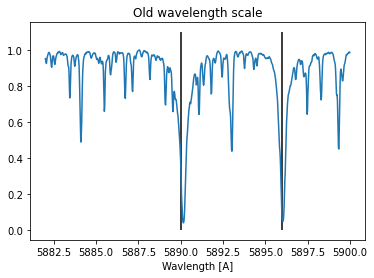

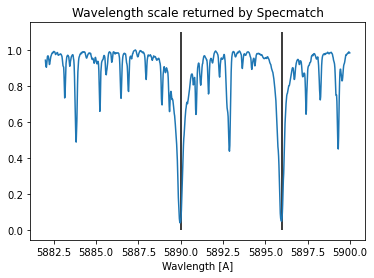

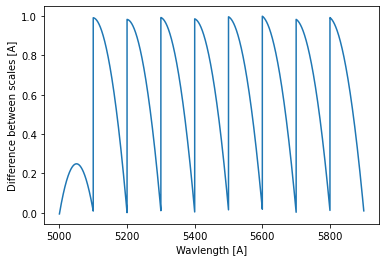

In [100]:
#check that target is registered properly, will plot this against keck version to check
mt_lincomb = sm.lincomb_matches[0:9]
wl_regions = [[5000,5100],[5101,5200],[5201,5300],[5301,5400],[5401,5500],[5501,5600],[5601,5700],[5701,5800],[5801,5900]]
wl_all_regions = np.zeros([0,0])
output_target = np.zeros([0,0]) 
actual_wl = np.zeros([0,0]) 
for n in range(9): 
    spect = mt_lincomb[n].target.s
    wl = np.linspace(wl_regions[n][0], wl_regions[n][1], len(spect))
    output_target = np.append(output_target, spect)
    wl_all_regions = np.append(wl_all_regions, wl) 
    actual_wl = np.append(actual_wl, mt_lincomb[n].target.w)
plt.figure()
idxs_of_order45 = np.where((5882 < wl_all_regions) * (wl_all_regions < 5900))
plt.plot(wl_all_regions[idxs_of_order45],output_target[idxs_of_order45])
plt.vlines([5890,5896], 0, 1.1,)
plt.title('Old wavelength scale')
plt.xlabel('Wavlength [A]')

plt.figure()
idxs_of_order45 = np.where((5882 < actual_wl) * (actual_wl < 5900))
plt.plot(actual_wl[idxs_of_order45],output_target[idxs_of_order45])
plt.vlines([5890,5896], 0, 1.1,)
plt.title('Wavelength scale returned by Specmatch')
plt.xlabel('Wavlength [A]')

plt.figure()
plt.plot(actual_wl,wl_all_regions-actual_wl)
plt.xlabel('Wavlength [A]')
plt.ylabel('Difference between scales [A]')

In [234]:
# check method of returning pixel shift used during shifting
sm.shift_data

{'median_peaks/0': 1.778560086011896,
 'median_peaks/1': 1.8448938806205328,
 'median_peaks/2': 1.0053922438057346,
 'median_peaks/3': 0.9520119326108615,
 'shift_reference': 1,
 'num_orders': 1,
 'order_0/num_sections': 141,
 'order_0/sect_0/xcorr': array([0.00050053, 0.00053104, 0.00056345, ..., 0.00043837, 0.00045413,
        0.00047669]),
 'order_0/sect_0/lag_arr': array([-511., -510., -509., ...,  510.,  511.,  512.]),
 'order_0/sect_1/xcorr': array([-0.00220084, -0.00211676, -0.00204119, ..., -0.00259353,
        -0.00243787, -0.00231422]),
 'order_0/sect_1/lag_arr': array([-511., -510., -509., ...,  510.,  511.,  512.]),
 'order_0/sect_2/xcorr': array([0.00126417, 0.0012164 , 0.00117744, ..., 0.00151197, 0.00141064,
        0.00133235]),
 'order_0/sect_2/lag_arr': array([-511., -510., -509., ...,  510.,  511.,  512.]),
 'order_0/sect_3/xcorr': array([0.00066781, 0.00066195, 0.00066073, ..., 0.00070856, 0.00069134,
        0.00067737]),
 'order_0/sect_3/lag_arr': array([-511., -5

In [93]:
sm.to_hdf('./HIP101345_specmatch_object.hdf')

Saving SpecMatch object to HDF file


In [ ]:
figure(); plt.plot(sm.shift_data['lag'],'.-')

In [79]:
#figure(); plt.plot(sm.shift_data['order_0/sect_15/xcorr'],'.-')
all_plt.fimax = []
for section in range(sm.shift_data['order_0/num_sections']):
    xcorr = sm.shift_data['order_0/sect_' + str(section) + '/xcorr']
    max_xcorr = np.argmax(xcorr)
    all_max = all_max + [max_xcorr]
print(all_max)
print('avg: '+ str(np.median(np.array(all_max))))
#shape(sm.shift_data['lag'][0])

[631, 632, 632, 631, 631, 631, 631, 631, 631, 631, 632, 631, 631, 631, 631, 631, 632, 632, 632, 631, 632, 631, 631, 631, 631, 631, 632, 632, 631, 631, 631, 631, 631, 632, 631, 631, 631, 631, 631, 631, 631, 114, 631, 108, 631, 631, 632, 632, 631, 631, 61, 631, 630, 632, 632, 631, 631, 631, 631, 314, 630, 631, 631, 631, 631, 631, 630, 631, 586, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 157, 632, 631, 631, 631, 481, 631, 630, 631, 631, 631, 631, 631, 631, 631, 425, 631, 630, 631, 631, 631, 631, 630, 631, 631, 632, 631, 631, 631, 630, 630, 630, 631, 67, 631, 631, 630, 630, 630, 631, 631, 631, 630, 631, 630, 630, 630, 631, 631, 631, 160, 631, 631, 630, 631, 661, 418, 630, 483, 631, 631]
avg: 631.0


In [ ]:
max_corr = np.argmax(xcorr)
npix = len(xcorr)
lag_arr = np.arange(-npix/2+1, npix/2+1, 1)

# select points around the peak and fit a quadratic
lag_peaks = lag_arr[max_corr-1:max_corr+2]
xcorr_peaks = xcorr[max_corr-1:max_corr+2]

p = np.polyfit(lag_peaks, xcorr_peaks, 2)
# peak is simply -p[1]/2p[0]
lag = -p[1] / (2*p[0])

In [58]:
#plt.figure(); plt.plot(xcorr,'.-')
#shape(p)
#max_corr
#sm.target.s.shape[0]


TypeError: 'SpecMatch' object is not subscriptable

In [ ]:
# check moethod of removing star from library before running on that star
from astroquery.simbad import Simbad
import pandas as pd
HIP_names = pd.read_csv('Star_list.csv')['HIP_NAME'] 
for HIP_name in HIP_names:  
    #yee_names = pd.read_csv('yee_library_full.csv')['Name'].to_list()
    lib_names = lib.library_params['cps_name'].to_list()
    print(HIP_name)
    result_table = Simbad.query_objectids(HIP_name)
    alt_names = result_table.to_pandas()
    alt_names = alt_names.iloc[:,0].str.decode('utf-8') #gets rid of weird formatting
    #library_name = [name.strip(' ') for name in yee_names if name.strip(' ') in alt_names.to_list()]
    #lib_name  = library_name[0].replace(' ','').replace('HD','')
    if HIP_name == 'HIP80824':
        lib_name = 'GJ628'
    else:
        lib_name = [name.replace(' ','').replace('HD','').replace('GJ','GL') for name in alt_names.to_list() if name.replace(' ','').replace('HD','').replace('GJ','GL') in lib_names]
    print('lib name: ' + lib_name[0])
    idx = lib.get_index(lib_name)
    star = lib.pop(idx)
    print('removing star: ' + star[0]['cps_name'])
    if idx == []:
        break
    print('   at idx: ' + str(idx))

In [223]:
lib = specmatchemp.library.read_hdf()

Reading library from /home/azuckerman/.specmatchemp/library.h5


In [236]:
# check method of saving SpecMatch object to hdf
sm.to_hdf('./Specmatch_objects/test.hdf')

Saving SpecMatch object to HDF file
